<a href="https://colab.research.google.com/github/Fragoa/Regularizing-Neural-Networks/blob/main/Regularizing_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Peprocessing

In [47]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()
x = np.concatenate([x_train_full, x_test])
y = np.concatenate([y_train_full, y_test])

In [48]:
x = x.astype('float32') / 255.0
x = x.reshape(-1, 28 * 28)

x_small, _, y_small, _ = train_test_split(x, y, test_size=0.95, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_small, y_small, test_size=0.2, random_state=42)

# Training Models

In [49]:
def build_model_M1():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(784,)),
        layers.Dense(12, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [50]:
def build_model_M1_L1(l1_lambda):
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(12, activation='relu',
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
model_M1 = build_model_M1()
history_M1 = model_M1.fit(x_train, y_train,
                          epochs=20,
                          batch_size=32,
                          validation_data=(x_val, y_val),
                          verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
train_acc_M1 = history_M1.history['accuracy'][-1]
val_acc_M1 = history_M1.history['val_accuracy'][-1]

print(" M1 (no regularization):")
print(f"   - Train Accuracy:      {train_acc_M1:.4f}")
print(f"   - Validation Accuracy: {val_acc_M1:.4f}")
if train_acc_M1 - val_acc_M1 > 0.05:
    print("    Likely overfitting detected.")
else:
    print("    No significant overfitting.")


 M1 (no regularization):
   - Train Accuracy:      0.9664
   - Validation Accuracy: 0.8743
    Likely overfitting detected.


In [57]:
lambda_val = 1e-7
model_M1_L1 = build_model_M1_L1(lambda_val)
history_M1_L1 = model_M1_L1.fit(x_train, y_train,
                                epochs=20,
                                batch_size=32,
                                validation_data=(x_val, y_val),
                                verbose=0)


In [61]:
train_acc = history_M1_L1.history['accuracy'][-1]
val_acc = history_M1_L1.history['val_accuracy'][-1]

print(f"\n Final accuracy of M1-L1 with λ = {lambda_val}:")
print(f"   - Train Accuracy:      {train_acc:.4f}")
print(f"   - Validation Accuracy: {val_acc:.4f}")

if train_acc - val_acc > 0.05:
    print(" Overfitting is likely present.")
else:
    print(" No significant overfitting detected.")



 Final accuracy of M1-L1 with λ = 1e-07:
   - Train Accuracy:      0.9743
   - Validation Accuracy: 0.8986
 Overfitting is likely present.


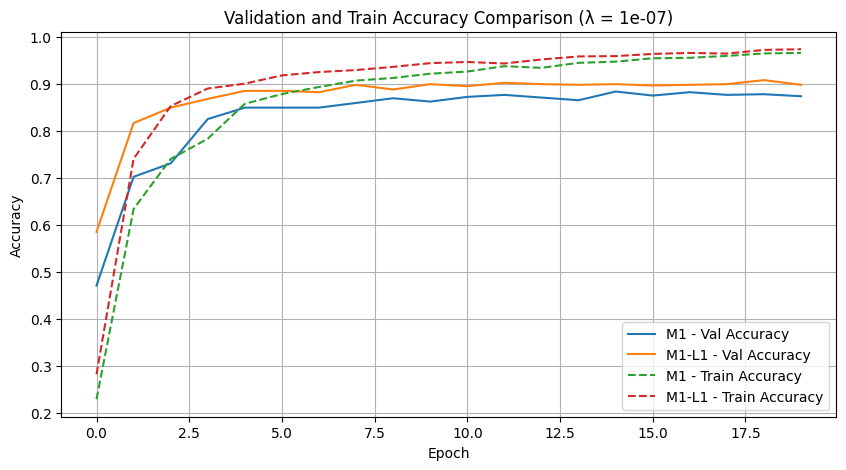

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(history_M1.history['val_accuracy'], label='M1 - Val Accuracy')
plt.plot(history_M1_L1.history['val_accuracy'], label='M1-L1 - Val Accuracy')
plt.plot(history_M1.history['accuracy'], '--', label='M1 - Train Accuracy')
plt.plot(history_M1_L1.history['accuracy'], '--', label='M1-L1 - Train Accuracy')
plt.title(f'Validation and Train Accuracy Comparison (λ = {lambda_val})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
lambda_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = []

In [64]:
def train_model_with_l1(lambda_val):
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l1(lambda_val)),
        layers.Dense(12, activation='relu',
                     kernel_regularizer=regularizers.l1(lambda_val)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        epochs=15,  # fewer epochs for speed
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

In [65]:
for lmbd in lambda_values:
    hist = train_model_with_l1(lmbd)
    train_acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    results.append((lmbd, train_acc, val_acc))

print("\n λ Grid Search Results:")
for lmbd, train_acc, val_acc in results:
    overfit_gap = train_acc - val_acc
    print(f"  λ = {lmbd:.0e} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Gap = {overfit_gap:.4f}")

# Select best λ (lowest overfit with high val accuracy)
results_sorted = sorted(results, key=lambda x: (-(x[2]), abs(x[1] - x[2])))  # sort by val_acc desc, gap asc
best_lambda = results_sorted[0][0]

print(f"\n✅ Optimal λ found: λ_opt = {best_lambda:.0e}")


🔎 λ Grid Search Results:
  λ = 1e-06 | Train Acc = 0.9589 | Val Acc = 0.8900 | Gap = 0.0689
  λ = 1e-05 | Train Acc = 0.9707 | Val Acc = 0.8929 | Gap = 0.0779
  λ = 1e-04 | Train Acc = 0.9643 | Val Acc = 0.9014 | Gap = 0.0629
  λ = 1e-03 | Train Acc = 0.9275 | Val Acc = 0.8700 | Gap = 0.0575
  λ = 1e-02 | Train Acc = 0.8179 | Val Acc = 0.7757 | Gap = 0.0421
  λ = 1e-01 | Train Acc = 0.1164 | Val Acc = 0.1157 | Gap = 0.0007

✅ Optimal λ found: λ_opt = 1e-04


In [66]:
def train_model_with_l2(lambda_val):
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(784,),
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dense(12, activation='relu',
                     kernel_regularizer=regularizers.l2(lambda_val)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        epochs=15,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

In [67]:
# Train models for different λ values
for lmbd in lambda_values:
    histـl2 = train_model_with_l2(lmbd)
    train_acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    results.append((lmbd, train_acc, val_acc))

In [68]:
# Print results
print("\n λ Grid Search Results (L2):")
for lmbd, train_acc, val_acc in results:
    overfit_gap = train_acc - val_acc
    print(f"  λ = {lmbd:.0e} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Gap = {overfit_gap:.4f}")

# Find best lambda: highest val_acc with lowest overfitting
results_sorted = sorted(results, key=lambda x: (-x[2], abs(x[1] - x[2])))
best_lambda = results_sorted[0][0]

print(f"\n Optimal λ found for L2: λ_opt = {best_lambda:.0e}")


 λ Grid Search Results (L2):
  λ = 1e-06 | Train Acc = 0.9589 | Val Acc = 0.8900 | Gap = 0.0689
  λ = 1e-05 | Train Acc = 0.9707 | Val Acc = 0.8929 | Gap = 0.0779
  λ = 1e-04 | Train Acc = 0.9643 | Val Acc = 0.9014 | Gap = 0.0629
  λ = 1e-03 | Train Acc = 0.9275 | Val Acc = 0.8700 | Gap = 0.0575
  λ = 1e-02 | Train Acc = 0.8179 | Val Acc = 0.7757 | Gap = 0.0421
  λ = 1e-01 | Train Acc = 0.1164 | Val Acc = 0.1157 | Gap = 0.0007
  λ = 1e-06 | Train Acc = 0.9693 | Val Acc = 0.9000 | Gap = 0.0693
  λ = 1e-05 | Train Acc = 0.9636 | Val Acc = 0.8986 | Gap = 0.0650
  λ = 1e-04 | Train Acc = 0.9575 | Val Acc = 0.8943 | Gap = 0.0632
  λ = 1e-03 | Train Acc = 0.9607 | Val Acc = 0.9000 | Gap = 0.0607
  λ = 1e-02 | Train Acc = 0.9300 | Val Acc = 0.8900 | Gap = 0.0400
  λ = 1e-01 | Train Acc = 0.7929 | Val Acc = 0.7657 | Gap = 0.0271

 Optimal λ found for L2: λ_opt = 1e-04
